![DeepNeuro](https://github.com/QTIM-Lab/DeepNeuro/raw/master/package_resources/logos/DeepNeuro_alt.PNG?raw=true)

# Loading, Preprocessing, and Augmenting Data Using DeepNeuro

In this notebook, you will learn how to load, preprocess, and augment data with DeepNeuro. DeepNeuro loads data from either structure folders, filepaths, or .csv files into DataCollection objects. DataCollection objects have pre-coded methods to perform data preprocessing, data augmentation, and patch extraction. They also can be automatically sampled for the purpose of training neural networks with DeepNeuro's DeepNeuroModel objects.

You are going to get started creating a DataCollection object and applying some preprocessing steps. First, however, you need to get DeepNeuro installed, and import the package.

In [1]:
# Uncomment the following three lines if you are running this notebook in Google Colab
# !apt update
# !apt install -y cmake
# from google.colab import files

#!pip3 install deepneuro tensorflow-gpu keras

import os
import warnings

warnings.filterwarnings("ignore", message=".*dtype size changed.*")
warnings.filterwarnings("ignore", message=".*keepdims.*")
warnings.filterwarnings("ignore", message=".*pydicom.*")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

import deepneuro

You will work with two datasets from the TCGA-GBM dataset for this tutorial, available from The Cancer Imaging Archive (TCIA) and this link: [link](https://wiki.cancerimagingarchive.net/display/Public/TCGA-GBM).

We will load this dataset using DeepNeuro's load module into a local folder in your Colab directory.

In [2]:
from deepneuro.load.load import load

load('sample_gbm_nifti', output_datapath='./Sample_Data')

'./Sample_Data/TCGA_GBM_NIFTI.zip'

You should see two folders labeled 'TRAINING' and 'TESTING' contained within a folder titled 'TCGA_GBM_NIFTI'. Both of these folders contain individual patient folders, and each of these contain five NiFTi files each. Four of these files should code for different MR sequences of a patient with glioblastoma. The other file should be a segmentation file, containing voxelwise annotations for enhancing tumor, necrotic tissue, and edematous tissue in the brain.

For most deep learning experiments, you should hopefully have more than three patients. For this tutorial, however, we will stick with three because it's faster to load data that way :). We will have two patients in the training set, and one patient in the test set.

Let's start with our training data. Our first step will be to associate this two-patient dataset with a DataCollection, DeepNeuro's one-size-fits-all data processing object for data conversion, preprocessing, and augmentation.

In [3]:
from deepneuro.data.data_collection import DataCollection

training_data_sources = {
    'directories': {
                './Sample_Data/GBM_NIFTI/TRAINING':
                {'input_data': ['*_flair.nii.gz*', '*_t2.nii.gz*', '*_t1.nii.gz', '*_t1Gd.nii.gz'], 
                 'ground_truth': ['*GlistrBoost_ManuallyCorrected.nii.gz']}},
}

training_data = DataCollection(data_sources=training_data_sources, verbose=True, slice_index=60)

('Gathering image data from...', {'./Sample_Data/GBM_NIFTI/TRAINING': {'ground_truth': ['*GlistrBoost_ManuallyCorrected.nii.gz'], 'input_data': ['*_flair.nii.gz*', '*_t2.nii.gz*', '*_t1.nii.gz', '*_t1Gd.nii.gz']}}, '\n')
('Found', 2, 'cases..')


Great, it worked! But what does it mean to have your data in a DataCollection? We can start to get a sense using DeepNeuro's check_data function.

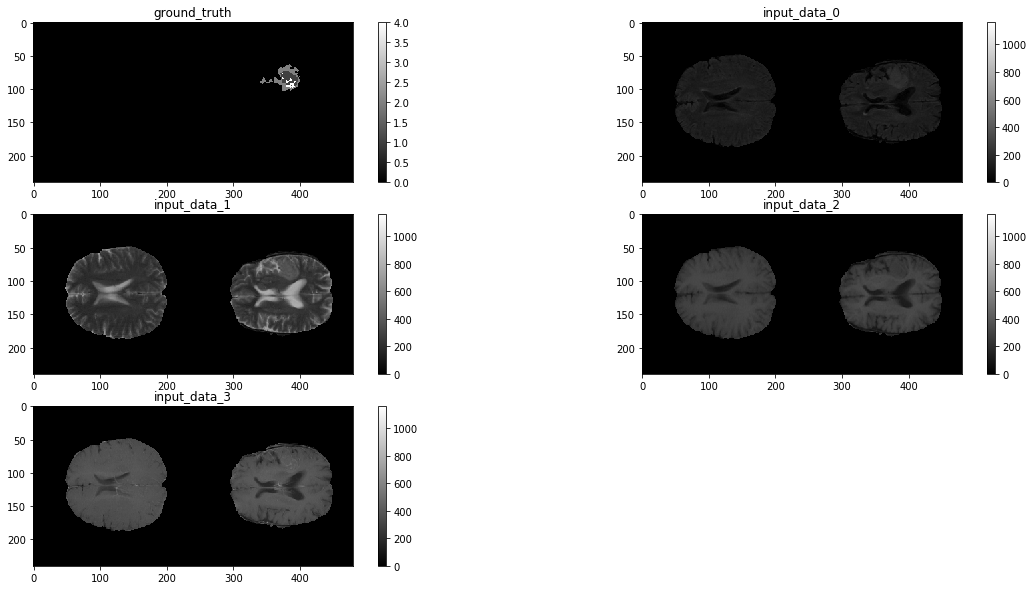

In [4]:
# We start off with some code to making plotting in Juypter/Colab Notebooks work correctly.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

from deepneuro.utilities.visualize import check_data

figure = check_data(data_collection=training_data, batch_size=64, viz_rows=1, slice_index=85)

We can see the four sequences of our datasets labeled 0, 1, 2, and 3. We can also see our "ground truth", the multi-tissue tumor segmentation.

So, we have our data available via a DataCollection. Can we start deep learning on it? No! Here are a few reasons:
- As we can see from the intensity range bars in the figure above, MR patient data is scaled variably between 0 and 1000+. Because we don't know if they came from the same scanner or precisely the same sequence, we do not have assurances that these values will be on the same scale from patient to patient. Also, inputs to neural networks are conventional scaled to have a mean centered on zero and a standard deviation of 1, which our sequences certainly do not have.

- Our ground truth is scaled from 0 to 4. Most deep learning cost functions for classification expect one-hot encoding. This means that each relevant classification is either 0 or 1, and that each class if separated into a different channel of the image. We will likely have training problems down the way if we do not adjust our data.

- Can you train a machine learning algorithm on two pieces of data? Not likely! And even if you could, how are you going to fit a whole MRI scan into memory on anything but the most powerful GPUs? A common solution to both of these problems is to split your data into smaller patches, decreasing memory requirements and increasing effective dataset size. There are also other data augmentations that can be put into place to push the effective size of our data even higher.

Luckily, DeepNeuro has utilities for performing each of these preprocessing steps and augmentations. We cover them below.

## Normalization for MR Sequence Data

MR images from different scanners and different sequences are not gauruanteed to have intensity values. To remedy this, we will perform a common preprocessing step in deep learning: zero-mean normalization. This preprocessing step simply ensures that all of our data will have a mean of 0, by subtracting each sequence's mean value from the total, and a variance of 1, by divided all intensities by resulting variance of the data.

We accomplish this by creating a ZeroMeanNormalization object in DeepNeuro, and applying it to our data collection using the append_preprocessor command. We can check the data after we're done, and see if the normalization is reflected in the intensity bars on each image.

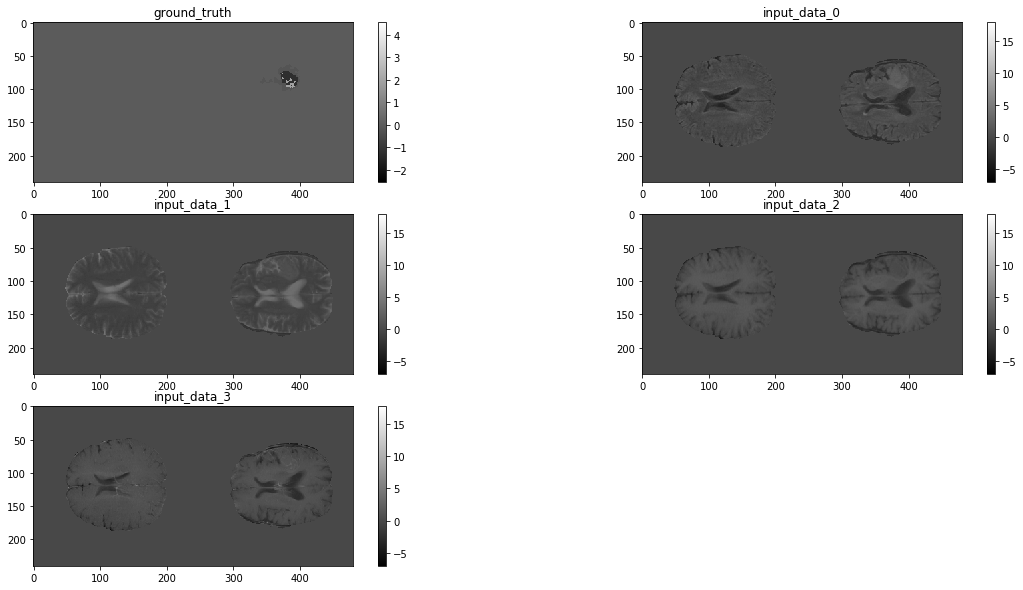

In [5]:
from deepneuro.preprocessing.signal import ZeroMeanNormalization

normalization_preprocessor = ZeroMeanNormalization(normalize_by_channel=True, 
                                                   mask_zeros=True)
training_data.append_preprocessor(normalization_preprocessor)

figure = check_data(data_collection=training_data, viz_rows=1, batch_size=2, slice_index=85)

## Reformatting for Voxelwise Segmentation Data

When creating a neural network, one has a few options for cost functions. Some of these cost functions might require to reformat your ground-truth data, so that it can be properly calculated by your chosen deep learning package. One such example is the categorical cross-entropy loss, often used for multi-category (non-binary) classification problems. 

Categorical cross-entropy requires one-hot encoding for labels, which means label should a) occupy its own channel and b) be binary-valued (0/1). Unfortunately, our test data is all combined into one channel, and tissue values range from 0-4 (there is no '3' in this dataset, as this category was eliminated in this year's version of the dataset).

To reformat our data, we will load the SplitData preprocessor object, and apply it to our training_data collection. We will make sure to specify that this only applies to our ground truth labels, and visualize the results.

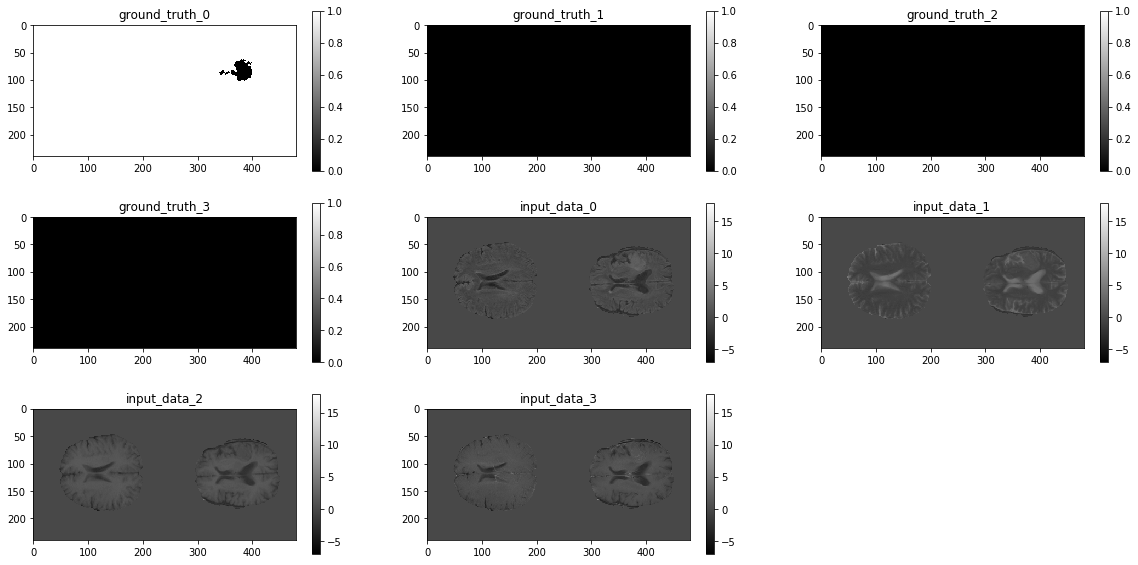

In [6]:
from deepneuro.preprocessing.transform import SplitData

one_hot_preprocessor = SplitData(data_groups=['ground_truth'], 
                                 label_splits=[0, 1, 2, 4],
                                 verbose=False)
training_data.append_preprocessor(one_hot_preprocessor)

figure = check_data(data_collection=training_data, viz_rows=1, batch_size=2, slice_index=85)

## Augmentation -- Patch Extraction

Right now, we have datasets from two patients. Two patients does not a good training dataset make. Fortunately, we can augment our data using the ExtractPatches augmentation object in DeepNeuro.

We are going to extract 200 patches from each of the patients in our training case, each 32x32x32 voxels, and train our model on those instead. We're also going to extract them in a specific way. If patches were extracted randomly from the entire space of the brain, there is a high liklihood that most of the patches would not overlap with cancerous tissue. For that reasons, we specify "patch regions". 

One region is the "brain region" which is everywhere inside the confines of the brain, but outside the our regions of interest. The other region is the "roi region", which is everywhere inside the tissues of interest. We can then control the ratio of these two types of patches we want to sample from. In this case, we will take 70% of our patches from the ROI region, and 30% of our patches from the brain region.

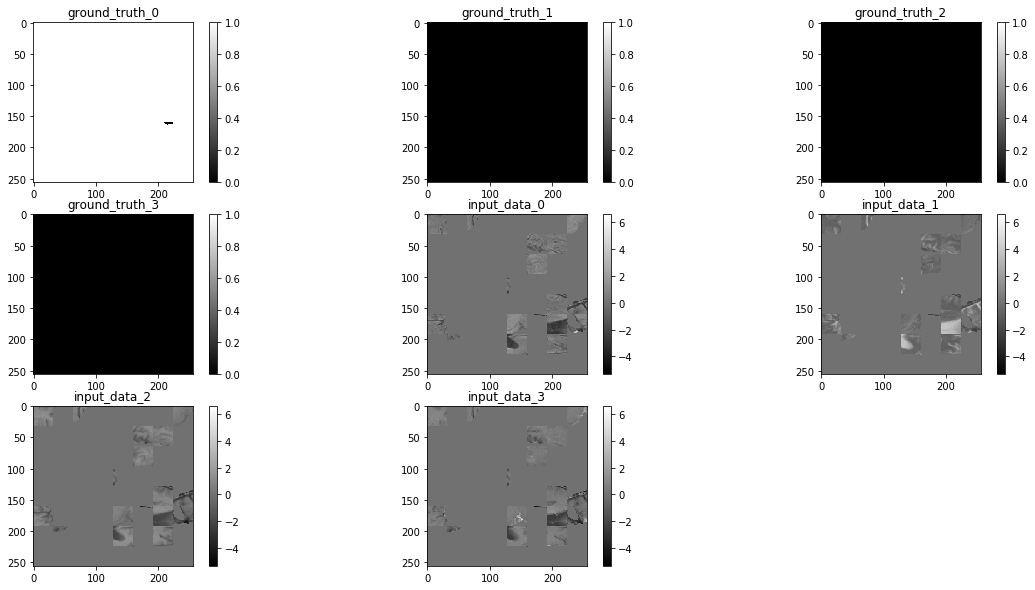

In [7]:
from deepneuro.augmentation.subsample import ExtractPatches

# Define patch sampling regions
def brain_region(data):
    return data['ground_truth'][..., 0] == 1

def roi_region(data):
    return data['ground_truth'][..., 1:] != 0

# Add patch augmentation
patch_augmentation = ExtractPatches(patch_shape=(32, 32, 32), 
                                    patch_region_conditions=[[brain_region, .3], [roi_region, .7]], 
                                    data_groups=['input_data', 'ground_truth'])
training_data.append_augmentation(patch_augmentation, multiplier=200)

# We've dropped some of the parameters for check_data here. check_data's default behavior is to
# grab the centermost axial slice in a given 3D volume. Earlier, that would result in an mostly
# uninteresting slice in the cerebellum, so we overrode that behavior with the slice_index and
# viz_mode_3d parameters to get a more interesting slice to look at. For patches, we don't need
# to do that.
figure = check_data(data_collection=training_data, batch_size=64)

## Augmentation -- Rotations and Flips

So 200x2 patients brings us up to 400 patches. But there are many other ways to augment data aside from simply divvying it up into patches. One simple way is to apply rotations and flips. Four 90 degree rotations with an optional flip effectively multiplies your data by 8 times, bringing up your total number of training patches to 3200.

We apply a flip/rotation augmentation using DeepNeuro's Flip_Rotate_2D augmentation object below. We do our rotating and flipping in the axial plane, although other utilites exist for doing arbitrary rotations in 3D space.

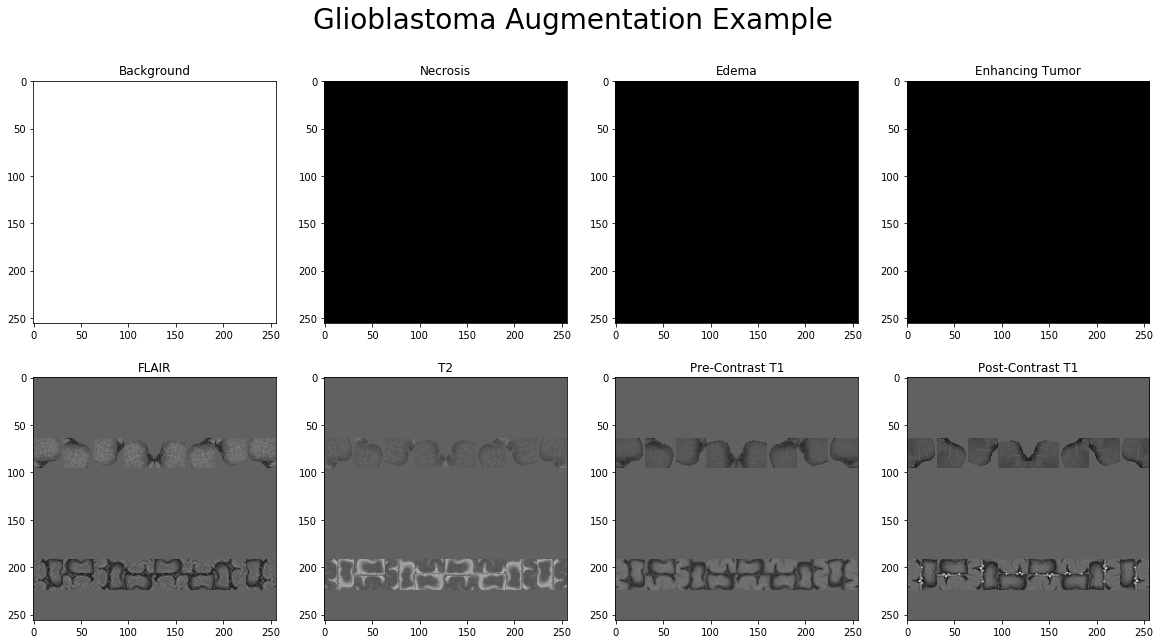

In [8]:
from deepneuro.augmentation.augment import Flip_Rotate_2D

flip_augmentation = Flip_Rotate_2D(flip=True, 
                                   rotate=True, 
                                   data_groups=['input_data', 'ground_truth'], 
                                   flip_axis=2)
training_data.append_augmentation(flip_augmentation, multiplier=8)

figure = check_data(data_collection=training_data, batch_size=64, subplot_rows=2, colorbar=False, 
                    title="Glioblastoma Augmentation Example",
                    subplot_titles={'input_data':['FLAIR', 'T2', 'Pre-Contrast T1', 'Post-Contrast T1'], 'ground_truth':
                                  ['Background', 'Necrosis', 'Edema', 'Enhancing Tumor']})

## Saving to HDF5

So, to review, we now have 3200 pieces of data. DeepNeuro has the ability to do live augmentation during training, which means we do not actually have to create any HDF5s to train a neural network. However, for some steps in this pipeline -- particularly the patch extraction -- it will save time to pre-load patches, rather than always creating them on the fly. Furthermore, saving HDF5 data means that we can shuffle through the data efficiently when performing data augmentation, instead of having to load several different patients into memory to get a random sample.

How do we save to HDF5 format? Pretty easily! DataCollections have a built-in function called write_data_to_file that dumps all available data, preprocessed and augmented, into a given HDF5 file.

In [9]:
output_hdf5_file = 'training_brain_patches.hdf5'

training_data.write_data_to_file(output_hdf5_file)

# Save your data locally if you are using Colab.
# files.download(output_hdf5_file)

100%|██████████| 2/2 [00:12<00:00,  6.13s/datasets]entations/s]


## Loading from HDF5

So say you want to write a new script in DeepNeuro, and load data from your old HDF5 file. Easy! Just create a new data collection, and set your data_sources parameter to your saved HDF5.

We do so below, and use the check_data function to make sure everything looks alright.

('Found', 3200, 'cases..')


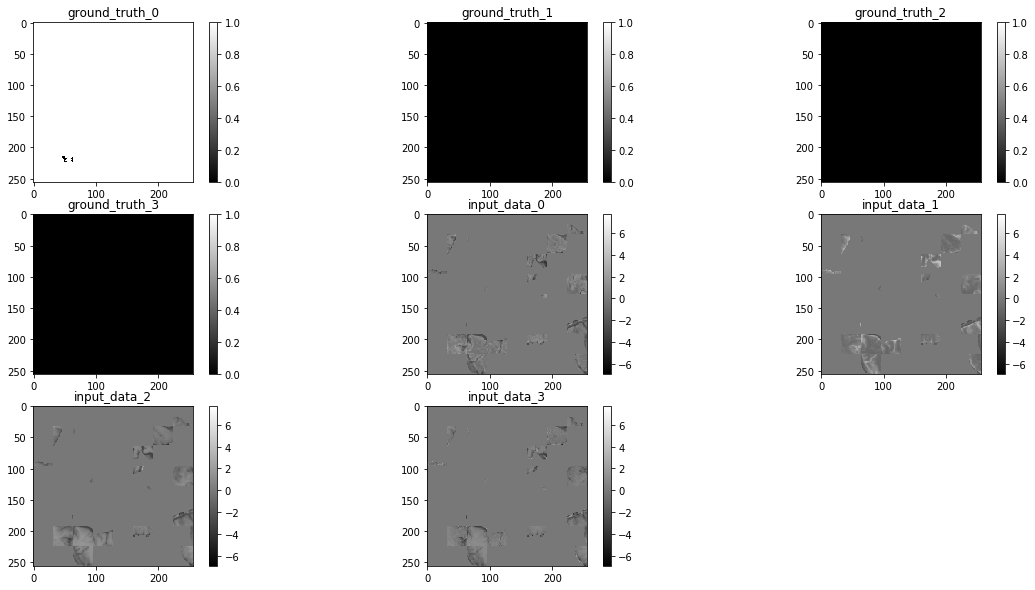

In [10]:
loaded_training_data = DataCollection(data_sources={'hdf5': 'training_brain_patches.hdf5'})

figure = check_data(data_collection=loaded_training_data, batch_size=64)

Note that the output is shuffled this time -- rotated and flipped patches are not found next to each other. The advantages of pre-loading data!

## And there you have it!

You have preprocessed and augmented some MRI data, and are now ready to train a neural network on it. Find out how to do that on the other tutorial found at https://github.com/QTIM-Lab/DeepNeuro.


## Data Citation

Segmentations and data made available in this tutorial were originally downloaded from: https://wiki.cancerimagingarchive.net/display/DOI/Segmentation+Labels+and+Radiomic+Features+for+the+Pre-operative+Scans+of+the+TCGA-GBM+collection.

Spyridon Bakas, Hamed Akbari, Aristeidis Sotiras, Michel Bilello, Martin Rozycki, Justin Kirby, John Freymann, Keyvan Farahani, and Christos Davatzikos. (2017) Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-GBM collection. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2017.KLXWJJ1Q